# 市场底部特征分析

In [2]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/24298
# 标题：市场底部特征研究

from jqdata import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# 画图
def Draw_param(df,param,x='index'):
    fig,ax=plt.subplots(1,1,figsize=(10,6))
    ax.plot(eval('df.'+x),df['000001.XSHG'],color='b',label='上证综指')
    plt.legend(loc=1)
    ax1=ax.twinx()
    ax1.plot(eval('df.'+x),df[param],color='y',label=param)
    plt.legend(loc=2)
    plt.title('%s与上证综指对比图'%param)
    plt.show()

# 1、股价低于2元个股占比

In [3]:
# 股价低于2元个股占比
def f1(count=3000):
#     count;取多少根K线
    all_stock = list(get_all_securities(types='stock').index)
    #注意为非复权价格,只能指定行数，不能指定日期，使用get_price的问题是，pandas后面不支持panel
#     df = get_price(all_stock,start_date='2018-7-1',end_date='2019-8-31',fields=['close'],fq=None)['close']
    df=history(count, unit='1d', field='close', security_list=all_stock, df=True, skip_paused=False, fq=None)
#     由于我们选取当前日期，获取的股票列表，一些股票上市之前的价格为NAN,我只需要用一个大于2的数字填充，即可避免出错，又不影响统计。
    df.fillna(10,inplace=True)
    #把数据转换成bool，方面后面快速统计，pandas中避免用循环，这将是一个灾难
    df1=df<2
    df1['count']=df1.apply(lambda x: x.sum(), axis=1)
#     获取每日股票总数
    df1['total']=[len(get_all_securities(types='stock',date=i)) for i in df1.index]
    d=history(count, unit='1d', field='close', security_list='000001.XSHG', df=True, skip_paused=False, fq=None)
    d['low_2']=df1['count']/df1['total']
    d.dropna(inplace=True)
    return d
    

In [4]:
df1=f1()
df1.head()

,000001.XSHG,low_2
2008-04-18,3094.67,0.00451
2008-04-21,3116.98,0.00451
2008-04-22,3147.79,0.00451
2008-04-23,3278.33,0.00451
2008-04-24,3583.03,0.00451


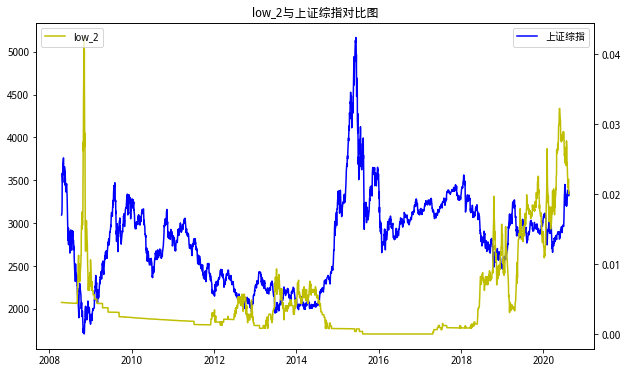

In [9]:
Draw_param(df1,'low_2')

# 2、 破净个股数，市场占比

In [5]:
# 破净个股数，市场占比
def f2(count=3000):
    all_stock = list(get_all_securities(types='stock').index)
    df=history(count, unit='1d', field='close', security_list='000001.XSHG', df=True, skip_paused=False, fq=None)
    df.dropna(inplace=True)
    df['count']=[len(get_fundamentals(query(valuation.code,valuation.pb_ratio).filter(valuation.pb_ratio<1),date=i)) for i in df.index]
    df['total']=[len(get_all_securities(types='stock',date=i)) for i in df.index]
    df['lower_pb']=df['count']/df['total']
    return df

In [6]:
b=f2()
b.head()

,000001.XSHG,count,total,lower_pb
2008-04-18,3094.67,63,1552,0.040593
2008-04-21,3116.98,63,1552,0.040593
2008-04-22,3147.79,64,1552,0.041237
2008-04-23,3278.33,64,1552,0.041237
2008-04-24,3583.03,62,1552,0.039948


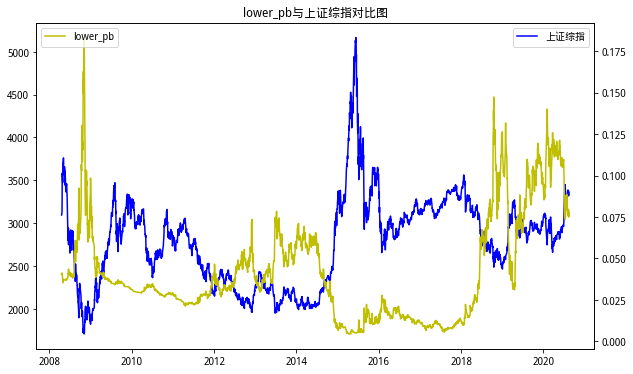

In [10]:
Draw_param(b,'lower_pb')

# 3、M2/总市值中位数

In [11]:
#M2/总市值中位数
def f3(count=120):
    from jqdata import macro
#     获取过去10年的M2的月度数据
    q = query(macro.MAC_MONEY_SUPPLY_MONTH.m2,
          macro.MAC_MONEY_SUPPLY_MONTH.stat_month)
    df = macro.run_query(q)
    df.sort_values('stat_month',inplace=True)
    df.reset_index(drop=True,inplace=True)
    df1=df.iloc[-count:,:]
    df1.reset_index(drop=True,inplace=True)
# 获取每个月市场中位数市值
    mid_cap=[]#存储市值中位数
    zhishu=[]#存储指数
    for i in df1.stat_month:
        d=get_fundamentals(query(valuation.code,
                                 valuation.day,
                                 valuation.market_cap
                                 ),date=i+'-10')
        b=d['market_cap'].median()
        mid_cap.append(b)
        #由于M2数据发布在月中，有的时候放假会推迟，具体哪个交易日不固定，因此我们取中旬的第一个交易日，提取市值中位数
        df = get_price('000001.XSHG',start_date=i+'-9',end_date=i+'-20',fields=['close'],fq=None)
        zhishu.append(df['close'][0])
    df1['mid_cap']=mid_cap
    df1['000001.XSHG']=zhishu
    df1['m2/mid_p']=round(df1.m2/df1.mid_cap,2)
    return df1

In [12]:
df3=f3(156)
df3.head()

,m2,stat_month,mid_cap,000001.XSHG,m2/mid_p
0,387205.04,2007-08,38.41890,4754.10,10078.50
1,393098.91,2007-09,44.27360,5355.29,8878.86
2,394204.17,2007-10,43.89000,5715.89,8981.64
3,399757.91,2007-11,36.54190,5315.54,10939.71
4,403401.30,2007-12,39.53915,5161.92,10202.58


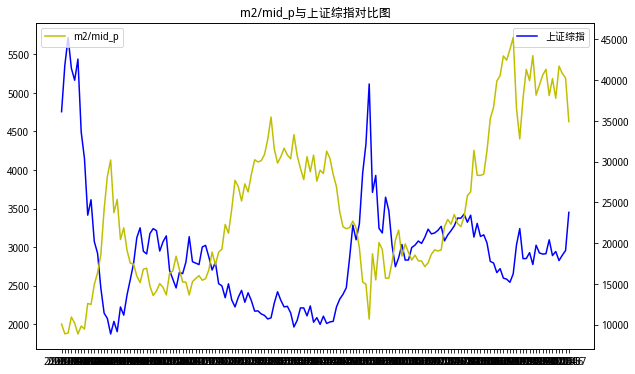

In [16]:
Draw_param(df3,'m2/mid_p',x='stat_month')

In [17]:
#PE中位数和十年国债收益率倒数的比较
def f4():
    pass

# 5、全市场成交额萎缩程度

In [18]:
#全市场成交额萎缩程度
#当日成交量/MAX(历史成交量)
#输出两个市场成交额数据变化
def f5(count=3000):
#     df1多加一年的数据的，减少初始数据影响
    df1=history(count+250, unit='1d', field='money', security_list=['399001.XSHE','000001.XSHG'], df=True, skip_paused=False, fq=None)
    df=history(count, unit='1d', field='close', security_list='000001.XSHG', df=True, skip_paused=False, fq=None)
    df1['total_m']=df1['399001.XSHE']+df1['000001.XSHG']
    max_money=[]
    for date in df.index:
        dfx=df1[df1.index<=date]
        max_money.append(dfx['total_m'].max())
    df['total_m']=df1['total_m'][-count:]
    df['max_m']=max_money
    df['Degree_shrinkage']=df['total_m']/df['max_m']
    return df

In [19]:
df5=f5()
df5.head()

,000001.XSHG,total_m,max_m,Degree_shrinkage
2008-04-18,3094.67,6.205842e+10,3.061202e+11,0.202726
2008-04-21,3116.98,9.190021e+10,3.061202e+11,0.300210
2008-04-22,3147.79,6.793175e+10,3.061202e+11,0.221912
2008-04-23,3278.33,9.581067e+10,3.061202e+11,0.312984
2008-04-24,3583.03,2.102832e+11,3.061202e+11,0.686930


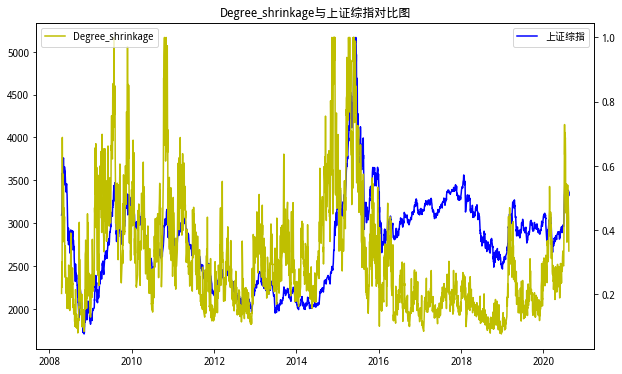

In [20]:
Draw_param(df5,'Degree_shrinkage')

In [21]:
df5.loc['2018-12-25',:]

000001.XSHG         2.504820e+03
total_m             1.863874e+11
max_m               1.868375e+12
Degree_shrinkage    9.975909e-02
Name: 2018-12-25 00:00:00, dtype: float64

# 6、个股平均成交金额

In [22]:
#返回个股平均成交金额
def f6(count=3000):
    df=f5(count)
#     获取每日交易个股数量
    all_stock = list(get_all_securities(types='stock').index)
    df1=history(len(df), unit='1d', field='paused', security_list=all_stock, df=True, skip_paused=False, fq=None)  
#     返回的数据，停牌个股为1，未上市个股的数据为NAN，用1来填充
    df1.fillna(1,inplace=True)
    #统计没有上市和停牌股票数量
    df1['count']=df1.apply(lambda x: x.sum(), axis=1)
    df1['stock_num']=len(all_stock)-df1['count']
    df['money_mean']=df['total_m']/df1['stock_num']
    return df

In [23]:
df6=f6()
df6.head()

,000001.XSHG,total_m,max_m,Degree_shrinkage,money_mean
2008-04-18,3094.67,6.205842e+10,3.061202e+11,0.202726,4.490479e+07
2008-04-21,3116.98,9.190021e+10,3.061202e+11,0.300210,6.583109e+07
2008-04-22,3147.79,6.793175e+10,3.061202e+11,0.221912,4.852268e+07
2008-04-23,3278.33,9.581067e+10,3.061202e+11,0.312984,6.785458e+07
2008-04-24,3583.03,2.102832e+11,3.061202e+11,0.686930,1.482956e+08


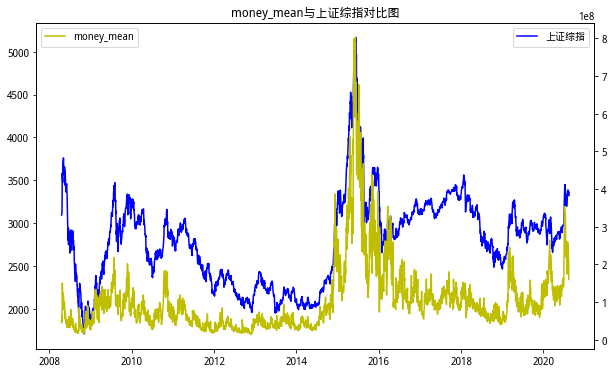

In [24]:
Draw_param(df6,'money_mean')

# 7、个股区间最大跌幅中位数

In [25]:

# 个人理解为相对于上一轮行情的最大回测，因此需要把行情划分为
def f7(count=3000):
    all_stock = list(get_all_securities(types='stock').index)
    df=history(count, unit='1d', field='close', security_list=all_stock, df=True, skip_paused=False, fq=None)
    for b, i in enumerate(df.index):
        df1 = df[df.index<=i]
        #回撤
        se = round(1-df1[-1:]/df1.max(),4)
        #格式为series
        mid=list(se.median(axis=1).values)
        if b==0:
            mid_decline=mid
        else:
            mid_decline=mid_decline+mid
    dfz=history(count, unit='1d', field='close', security_list='000001.XSHG', df=True, skip_paused=False, fq=None)
    dfz['min_decline']=mid_decline
    return dfz

In [26]:
df7=f7()
df7.head()

,000001.XSHG,min_decline
2008-04-18,3094.67,0.0000
2008-04-21,3116.98,0.0000
2008-04-22,3147.79,0.0254
2008-04-23,3278.33,0.0000
2008-04-24,3583.03,0.0000


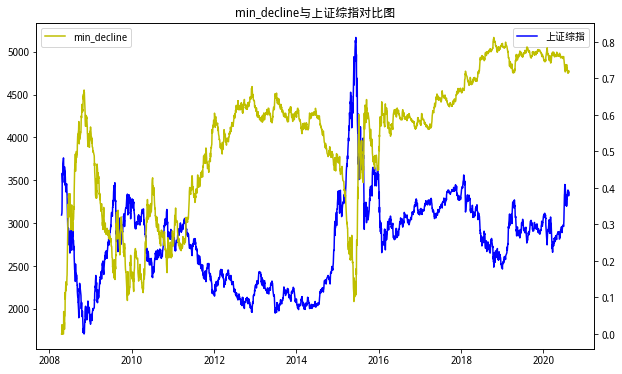

In [27]:
Draw_param(df7,'min_decline')

# 8、次新股的破发率、次新股PE中位、市场PE中位数

In [28]:
def f8(count=3000):
    # 获取全部股票信息
    df = get_all_securities(types='stock')
#     获取上市首日开盘价格，由于无法获取发行价，用首日开盘价代替
    df['fir_open']=[get_price(stock,end_date=df.loc[stock]['start_date'],count=1,fields=['open'])['open'].values[0] for stock in df.index]
#     获取所有个股每日收盘价
    df1= df1=history(count+500, unit='1d', field='close', security_list=list(df.index), df=True, skip_paused=False, fq=None) 
    dfz=history(count, unit='1d', field='close', security_list='000001.XSHG', df=True, skip_paused=False, fq=None)
#     破发率
    Breakage_rate=[]
    new_pe=[]
    pe_rate=[]
    for i in dfz.index:
        df['close']=df1.loc[i,:]
        date=i.date()
        date2=date-relativedelta(years=1)
        df3=df[pd.eval('df.start_date<date') & pd.eval('df.start_date>date2')]
#         有时候一年无新股
        if len(df3)==0:
            Breakage_rate.append(0)
            new_pe.append(new_pe[-1])
        else:
            df4=df3[df3['fir_open']>df3['close']]
#             次新股破发率
            Breakage_rate.append(round(len(df4)/len(df3),4))
#     获取次新股PE中位数
            d=date.strftime('%Y-%m-%d')
            sub_new=get_fundamentals(query(valuation.code,
                                           valuation.pe_ratio).filter(
                valuation.code.in_(list(df3.index))),date=d)
            new_pe.append(sub_new['pe_ratio'].median())
#         获取全市场PE中位数
        all_pe=get_fundamentals(query(valuation.code,
                                       valuation.pe_ratio).filter(
            valuation.code.in_(list(df.index))),date=d)
#         删去所有未上市的个股，
#         all_pe.dropna(axis=1,inplace=True)
        pe_rate.append(all_pe['pe_ratio'].median())
    dfz['Breakage_rate']=Breakage_rate
    dfz['new_pe']=new_pe
    dfz['pe_rate']=pe_rate
    return dfz       

In [29]:
df8=f8()
df8.head()

,000001.XSHG,Breakage_rate,new_pe,pe_rate
2008-04-18,3094.67,0.1466,38.9131,37.16750
2008-04-21,3116.98,0.1739,38.4905,36.23285
2008-04-22,3147.79,0.1826,38.1026,35.39325
2008-04-23,3278.33,0.1652,39.0405,36.87215
2008-04-24,3583.03,0.1130,42.3552,39.30170


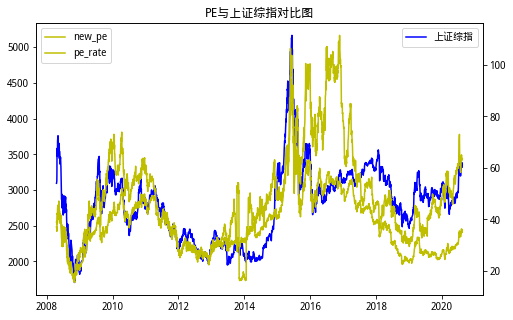

In [30]:
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.plot(df8.index,df8['000001.XSHG'],color='b',label='上证综指')
plt.legend(loc=1)
ax1=ax.twinx()
ax1.plot(df8.index,df8['new_pe'],color='y',label='new_pe')
ax1.plot(df8.index,df8['pe_rate'],color='y',label='pe_rate')
plt.legend(loc=2)
plt.title('PE与上证综指对比图')
plt.show()

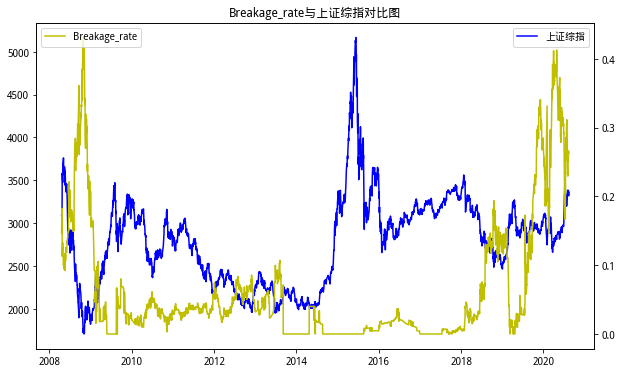

In [31]:
# 次新股破发率
Draw_param(df8,'Breakage_rate')

# 9、统计市场各个行业的相对估值状态

In [5]:
# 给行业打标签
def calc_state(data):
    if data < 0.1:
        return '极度低估'
    elif 0.1 <= data  and data < 0.2:
        return '低估'
    elif 0.2 <= data  and data < 0.4:
        return '正常偏低'
    elif 0.4 <= data  and data < 0.6:
        return '正常'
    elif 0.6 <= data  and data < 0.8:
        return '正常偏高'
    elif 0.8 <= data  and data < 0.9:
        return '高估'
    elif 0.9 <= data:
        return '极度高估'

In [32]:
# # 获取指数pe，pb值
# def get_index_quote(code,end_date=None,count=None,start_date=None):
#     '''获取中证指数行情'''
#     if isinstance(code,str):
#         code=[code]
#     code.sort()
#     code = [x[:6] for x in code]
#     days = get_trade_days(start_date,end_date,count)
#     code_df = jy.run_query(query(
#          jy.SecuMain.InnerCode,jy.SecuMain.SecuCode,jy.SecuMain.ChiName
#         ).filter(
#         jy.SecuMain.SecuCode.in_(code)).order_by(jy.SecuMain.SecuCode))
#     df = jy.run_query(query(jy.QT_CSIIndexQuote).filter(
#             jy.QT_CSIIndexQuote.IndexCode.in_(code_df.InnerCode),
#             jy.QT_CSIIndexQuote.TradingDay.in_(days),
#             ))
# #     有时候数据没有更新，特别是当天的数据，出来的数据少一条，会造成后面的数据表无法合并
#     if len(df)==count:
#         pass
#     else:
#         count=count+1
#         days = get_trade_days(start_date,end_date,count)
#         df = jy.run_query(query(jy.QT_CSIIndexQuote).filter(
#             jy.QT_CSIIndexQuote.IndexCode.in_(code_df.InnerCode),
#             jy.QT_CSIIndexQuote.TradingDay.in_(days),
#             ))
# #     合并两个表格，同时删除不需要的列
#     df2  = pd.merge(code_df, df, left_on='InnerCode',right_on='IndexCode')
#     df2.drop(['InnerCode','IndexCode','ID','UpdateTime','JSID','OpenInterest','SettleValue','IndexCSIType'],axis=1,inplace=True)
#     #return df2.to_panel()
#     df3=df2[['TradingDay','IndexPERatio2','IndexDYRatio2','TurnoverValue']]
#     #删除带空值的行，较早的数据有缺失
#     df4=df3.dropna(axis=0)
#     #重命名列名
#     df4.columns=['dt','PE','PB','vol']
#     return df4.reset_index(drop=True)

In [34]:
# def pe_pb_analysis(index_list=['000300.XSHG','000905.XSHG'],count=None,end_date=None,start_date=None):
    
#     '''PE_PB分析'''
#     all_index = get_all_securities(['index'])
#     pe_results = []
#     pe_code_list = []
#     pb_results = []
#     pb_code_list = []
#     #沪深
#     for code in index_list:
#         index_name = all_index.loc[code].display_name
#         df_pe_pb = get_index_quote(code,end_date=end_date,count=count,start_date=start_date)
#         #最长十年的数据
#         df_pe_pb = df_pe_pb[-244*10:]
                
#         pe_ratio = len(df_pe_pb.PE[df_pe_pb.PE<df_pe_pb.iloc[-1].PE])/float(len(df_pe_pb.PE))
#         pb_ratio = len(df_pe_pb.PB[df_pe_pb.PB<df_pe_pb.iloc[-1].PB])/float(len(df_pe_pb.PB))   
        
#         pe_results.append([index_name, df_pe_pb.iloc[-1].PE, '%.2f'%pe_ratio, calc_state(pe_ratio),
#                            min(df_pe_pb.PE), max(df_pe_pb.PE), '%.2f'%median(df_pe_pb.PE),
#                            '%.2f'%std(df_pe_pb.PE), df_pe_pb[0:1]['dt'].dt.strftime('%Y-%m-%d').tolist()[0]])
#         pb_results.append([index_name, df_pe_pb.iloc[-1].PB, '%.2f'%pb_ratio, calc_state(pb_ratio),
#                            min(df_pe_pb.PB), max(df_pe_pb.PB), '%.2f'%median(df_pe_pb.PB),
#                            '%.2f'%std(df_pe_pb.PB), df_pe_pb[0:1]['dt'].dt.strftime('%Y-%m-%d').tolist()[0]])
#         pe_code_list.append(code)
#         pb_code_list.append(code)
#     #date_str = pd.to_datetime(df_pe_pb.iloc[-1].name).date().strftime('%Y%m%d')
#     #date_str = df_pe_pb.iloc[-1]['dt']

#     pe_columns=['名称', '当前PE', 'PE百分位(%)', 'PE估值状态', 'PE最小', 'PE最大', 'PE中位数', 'PE标准差', '起始日期']
#     pe_df = pd.DataFrame(data=pe_results,index=pe_code_list,columns=pe_columns)
#     pe_df.index = pe_df['名称']
#     del pe_df['名称']
#     #pe_df.index.name = date_str
    
#     pb_columns=['名称', '当前PB', 'PB百分位(%)', 'PB估值状态', 'PB最小', 'PB最大', 'PB中位数', 'PB标准差', '起始日期']
#     pb_df = pd.DataFrame(data=pb_results,index=pb_code_list,columns=pb_columns)
#     pb_df.index = pb_df['名称']
#     del pb_df['名称']
#     #pb_df.index.name = date_str
#     pe_df.sort_values(['PE百分位(%)'],ascending=True,inplace=True)
#     pb_df.sort_values(['PB百分位(%)'],ascending=True,inplace=True)
#     pe_pb=pe_df.merge(pb_df,on=['名称','起始日期'],how='left')
# #     把'起始日期'这一列移动到最后一列
#     col= pe_pb.pop('起始日期')
#     pe_pb.insert(14,'起始日期',col)
#     return pe_df,pb_df,pe_pb

In [16]:
def Industry_valuation(count=2000,tp=28,cls=3,cs=3,start=None,end=None):
    '''
    tp：行业分类，目前只支持证监会行业分类和中证行业分类，12-中证指数行业分类，22-证监会行业分类2012版，23-证监会行业分类2012版(中证披露)，28-中证指数行业分类(2016版)，
    cs:1-个股统计 2-行业统计_证监会行业分类；3-行业统计_中证行业分类；4-板块统计。CS的选择与TS对应
    cls:1-一级行业；2-二级行业；3-三级行业；4-四级行业；5-五级行业；6-六级行业。
    相关参数，请参考聚源数据CT_IndustryType，LC_CSIIndusPE
    '''
    days = get_trade_days(start_date=start,end_date=end,count=count)
#     由于对取数据的数量进行了限制，降低为每5天取一次数据
    days=[str(days[k])  for k in range(len(days)) if k%5==0]
    df = jy.run_query(query(jy.CT_IndustryType).filter(jy.CT_IndustryType.Standard==tp,
                                                       jy.CT_IndustryType.Classification==cls))
    list1=df.IndustryName.values
    for a,types in enumerate(['PE','PB']):
        if types=='PE':
            A=2
            B='PE'
        else:
            A=3
            B='PB'
        for k,date in enumerate(days):
            df1 = jy.run_query(query(jy.LC_CSIIndusPE).filter(jy.LC_CSIIndusPE.StatRatio==A,
                                                              jy.LC_CSIIndusPE.StatType==cs,
                                                              jy.LC_CSIIndusPE.SecuName.in_(list1),
                                                              jy.LC_CSIIndusPE.TradingDate==date
                                                              ))
            df2=df1[['TradingDate','SecuName','RD']]
            try:
                df3=df2.rename(columns={'RD':df2.TradingDate.values[0].astype(str)[:10]})
            except IndexError:
                break
            df4=df3.drop('TradingDate',axis=1)
                #     删除nan行，重复的行
            df4.dropna(inplace=True)
            df4.drop_duplicates(inplace=True)
            if k==0:
                dfx=df4
            else:
                dfx=dfx.merge(df4,on='SecuName')
        dfx.set_index('SecuName',inplace=True)
        # 返回每个数字一行中的排序
        dfy=dfx.rank(axis=1)
        names=globals()
        names['dfx'+str(a)]=pd.DataFrame()
        names['dfx'+str(a)]['行业']=dfx.index
        names['dfx'+str(a)].set_index('行业',inplace=True)
        names['dfx'+str(a)]['当前'+B]=dfx.iloc[:,-1]
        names['dfx'+str(a)][B+'百分位']=dfy.iloc[:,-1]/(dfy.shape[1])
        names['dfx'+str(a)]['当前估值状态']=names['dfx'+str(a)][B+'百分位'].apply(calc_state)
        names['dfx'+str(a)][B+'最小']=dfx.min(axis=1)
        names['dfx'+str(a)][B+'最大']=dfx.max(axis=1)
        names['dfx'+str(a)][B+'中位数']=dfx.median(axis=1)
        names['dfx'+str(a)][B+'标准差']=dfx.std(axis=1)
    res = pd.concat([dfx0,dfx1],axis=1,join='inner',ignore_index=False)
    return res

df=Industry_valuation()
df

,当前PE,PE百分位,当前估值状态,PE最小,PE最大,PE中位数,PE标准差,当前PB,PB百分位,当前估值状态,PB最小,PB最大,PB中位数,PB标准差
行业,,,,,,,,,,,,,,
食品与主要用品零售,30.46,0.978261,极度高估,22.47,31.71,27.160,1.729496,2.97,0.972826,极度高估,2.22,3.06,2.690,0.182151
通信设备,43.37,0.896739,高估,25.33,47.99,35.365,5.723634,3.32,0.929348,极度高估,1.80,3.56,2.615,0.433635
化学制品,27.17,0.690217,正常偏高,20.01,29.55,26.260,2.455166,2.28,0.570652,正常,1.81,2.50,2.260,0.129594
建筑材料,16.61,0.456522,正常,10.65,23.64,17.015,3.268415,1.67,0.423913,正常,1.46,2.20,1.715,0.172876
容器与包装,30.23,0.809783,高估,22.38,33.37,27.005,2.903109,2.31,0.978261,极度高估,1.50,2.36,1.935,0.210471
纸类与林业产品,26.78,0.173913,低估,24.82,58.80,29.940,9.062845,2.09,0.967391,极度高估,1.33,2.14,1.850,0.232086
航空航天与国防,76.93,0.684783,正常偏高,47.51,91.13,67.705,10.299570,3.56,0.483696,正常,2.40,4.26,3.570,0.476858
建筑产品,29.30,0.804348,高估,21.49,32.57,27.405,2.456238,2.20,0.750000,正常偏高,1.74,2.39,2.100,0.129551
建筑与工程,8.15,0.130435,低估,7.71,12.50,10.320,1.330511,1.11,0.125000,低估,1.05,1.53,1.280,0.121198


,dt,PE,PB,vol
0,2020-08-03,14.94,2.13,5.724308e+11
1,2020-08-04,14.96,2.13,6.049421e+11
2,2020-08-05,14.99,2.12,5.265151e+11
3,2020-08-06,15.03,2.12,5.704882e+11
4,2020-08-07,14.89,2.14,5.614356e+11


# *题外

有了上述几个方面的数据后，我们就可以运用机器学习对行情顶部和底部特征进行分类，我们把历史高点10%的区间定义为顶部，我们把历史低点10%的区间定义为底部，进行打标签，后面有空做SVM或者随机森林。大家有什么其他的顶底特征，可以提出，我们继续完善数据。

In [ ]:
#用来找出聚宽数据库中有数据的指数，判断依据是至少有一条数据，
#估摸着这么专业的数据库里的指数应该不会只有一条数据吧，
#当然啦，有兴趣的话，你也可以改改下面的代码查下最早的数据时间
def get_JQ_INDEX_WITH_DATA():
    all_index=list(get_all_securities(types=['index']).index)
    index_with_data=[]
    for code in all_index:
        if len(get_zz_quote(code,count=1)):
            index_with_data.append(code)
    print('JQ有数据的指数个数为：',len(index_with_data))
    print(index_with_data)
    JQ_index=index_with_data.copy()
    JQ_index_name=[get_security_info(code).display_name for code in JQ_index]
    JQ_INDEX_WITH_DATA = dict(map(lambda x,y:[x,y],JQ_index,JQ_index_name))
    return JQ_INDEX_WITH_DATA

In [ ]:
#20191030聚宽数据库中有数据的指数
#跟踪ETF或基金的话可以取对应的指数
#行业轮动的话可以选一组指数
JQ_INDEX_WITH_DATA={'000001.XSHG': '上证指数',
 '000002.XSHG': 'A股指数',
 '000003.XSHG': 'B股指数',
 '000004.XSHG': '工业指数',
 '000005.XSHG': '商业指数',
 '000006.XSHG': '地产指数',
 '000007.XSHG': '公用指数',
 '000008.XSHG': '综合指数',
 '000009.XSHG': '上证380',
 '000010.XSHG': '上证180',
 '000011.XSHG': '基金指数',
 '000012.XSHG': '国债指数',
 '000013.XSHG': '上证企业债指数',
 '000015.XSHG': '红利指数',
 '000016.XSHG': '上证50',
 '000017.XSHG': '新综指',
 '000018.XSHG': '180金融',
 '000019.XSHG': '治理指数',
 '000020.XSHG': '中型综指',
 '000021.XSHG': '180治理',
 '000022.XSHG': '上证公司债指数',
 '000025.XSHG': '180基建',
 '000026.XSHG': '180资源',
 '000027.XSHG': '180运输',
 '000028.XSHG': '180成长',
 '000029.XSHG': '180价值',
 '000030.XSHG': '180R成长',
 '000031.XSHG': '180R价值',
 '000032.XSHG': '上证能源',
 '000033.XSHG': '上证材料',
 '000034.XSHG': '上证工业',
 '000035.XSHG': '上证可选',
 '000036.XSHG': '上证消费',
 '000037.XSHG': '上证医药',
 '000038.XSHG': '上证金融',
 '000039.XSHG': '上证信息',
 '000040.XSHG': '上证电信',
 '000041.XSHG': '上证公用',
 '000042.XSHG': '上证央企',
 '000043.XSHG': '超大盘',
 '000044.XSHG': '上证中盘',
 '000045.XSHG': '上证小盘',
 '000046.XSHG': '上证中小',
 '000047.XSHG': '上证全指',
 '000048.XSHG': '责任指数',
 '000049.XSHG': '上证民企',
 '000050.XSHG': '50等权',
 '000051.XSHG': '180等权',
 '000052.XSHG': '50基本',
 '000053.XSHG': '180基本',
 '000054.XSHG': '上证海外',
 '000055.XSHG': '上证地企',
 '000056.XSHG': '上证国企',
 '000057.XSHG': '全指成长',
 '000058.XSHG': '全指价值',
 '000059.XSHG': '全R成长',
 '000060.XSHG': '全R价值',
 '000061.XSHG': '沪企债30',
 '000062.XSHG': '上证沪企',
 '000063.XSHG': '上证周期',
 '000064.XSHG': '非周期',
 '000065.XSHG': '上证龙头',
 '000066.XSHG': '上证商品',
 '000067.XSHG': '上证新兴',
 '000068.XSHG': '上证资源',
 '000069.XSHG': '消费80',
 '000070.XSHG': '能源等权',
 '000071.XSHG': '材料等权',
 '000072.XSHG': '工业等权',
 '000073.XSHG': '可选等权',
 '000074.XSHG': '消费等权',
 '000075.XSHG': '医药等权',
 '000076.XSHG': '金融等权',
 '000077.XSHG': '信息等权',
 '000078.XSHG': '电信等权',
 '000079.XSHG': '公用等权',
 '000090.XSHG': '上证流通',
 '000091.XSHG': '沪财中小',
 '000092.XSHG': '资源50',
 '000093.XSHG': '180分层',
 '000094.XSHG': '上证上游',
 '000095.XSHG': '上证中游',
 '000096.XSHG': '上证下游',
 '000097.XSHG': '高端装备',
 '000098.XSHG': '上证F200',
 '000099.XSHG': '上证F300',
 '000100.XSHG': '上证F500',
 '000101.XSHG': '5年信用',
 '000102.XSHG': '沪投资品',
 '000103.XSHG': '沪消费品',
 '000104.XSHG': '380能源',
 '000105.XSHG': '380材料',
 '000106.XSHG': '380工业',
 '000107.XSHG': '380可选',
 '000108.XSHG': '380消费',
 '000109.XSHG': '380医药',
 '000110.XSHG': '380金融',
 '000111.XSHG': '380信息',
 '000112.XSHG': '380电信',
 '000113.XSHG': '380公用',
 '000114.XSHG': '持续产业',
 '000115.XSHG': '380等权',
 '000116.XSHG': '信用100',
 '000117.XSHG': '380成长',
 '000118.XSHG': '380价值',
 '000119.XSHG': '380R成长',
 '000120.XSHG': '380R价值',
 '000121.XSHG': '医药主题',
 '000122.XSHG': '农业主题',
 '000123.XSHG': '180动态',
 '000125.XSHG': '180稳定',
 '000126.XSHG': '消费50',
 '000128.XSHG': '380基本',
 '000129.XSHG': '180波动',
 '000130.XSHG': '380波动',
 '000131.XSHG': '上证高新',
 '000132.XSHG': '上证100',
 '000133.XSHG': '上证150',
 '000134.XSHG': '上证银行',
 '000135.XSHG': '180高贝',
 '000136.XSHG': '180低贝',
 '000137.XSHG': '380高贝',
 '000138.XSHG': '380低贝',
 '000139.XSHG': '上证转债',
 '000141.XSHG': '380动态',
 '000142.XSHG': '380稳定',
 '000145.XSHG': '优势资源',
 '000146.XSHG': '优势制造',
 '000147.XSHG': '优势消费',
 '000148.XSHG': '消费领先',
 '000149.XSHG': '180红利',
 '000150.XSHG': '380红利',
 '000151.XSHG': '上国红利',
 '000152.XSHG': '上央红利',
 '000153.XSHG': '上民红利',
 '000155.XSHG': '市值百强',
 '000158.XSHG': '上证环保',
 '000159.XSHG': '上证沪股通指数',
 '000160.XSHG': '上证一带一路主题指数',
 '000161.XSHG': '上证中国制造2025主题指数',
 '000162.XSHG': '上证互联网+主题指数',
 '000171.XSHG': '新兴成指',
 '000300.XSHG': '沪深300',
 '000801.XSHG': '资源80',
 '000802.XSHG': '500沪市',
 '000803.XSHG': '300波动',
 '000804.XSHG': '500波动',
 '000805.XSHG': 'A股资源',
 '000806.XSHG': '消费服务',
 '000807.XSHG': '食品饮料',
 '000808.XSHG': '医药生物',
 '000809.XSHG': '细分农业',
 '000810.XSHG': '细分能源',
 '000811.XSHG': '细分有色',
 '000812.XSHG': '细分机械',
 '000813.XSHG': '细分化工',
 '000814.XSHG': '细分医药',
 '000815.XSHG': '细分食品',
 '000816.XSHG': '细分地产',
 '000818.XSHG': '细分金融',
 '000819.XSHG': '有色金属',
 '000820.XSHG': '煤炭指数',
 '000821.XSHG': '300红利',
 '000822.XSHG': '500红利',
 '000824.XSHG': '国企红利',
 '000825.XSHG': '央企红利',
 '000826.XSHG': '民企红利',
 '000827.XSHG': '中证环保',
 '000828.XSHG': '300高贝',
 '000829.XSHG': '300低贝',
 '000830.XSHG': '500高贝',
 '000831.XSHG': '500低贝',
 '000832.XSHG': '中证转债',
 '000833.XSHG': '中高企债',
 '000838.XSHG': '创业价值',
 '000839.XSHG': '浙企综指',
 '000840.XSHG': '浙江民企',
 '000841.XSHG': '800医药',
 '000842.XSHG': '800等权',
 '000843.XSHG': '300动态',
 '000844.XSHG': '300稳定',
 '000846.XSHG': 'ESG100',
 '000852.XSHG': '中证1000指数',
 '000855.XSHG': '央视财经500指数',
 '000901.XSHG': '小康指数',
 '000902.XSHG': '中证流通',
 '000903.XSHG': '中证100',
 '000904.XSHG': '中证200',
 '000905.XSHG': '中证500',
 '000906.XSHG': '中证800',
 '000907.XSHG': '中证700',
 '000908.XSHG': '300能源',
 '000909.XSHG': '300材料',
 '000910.XSHG': '300工业',
 '000911.XSHG': '300可选',
 '000912.XSHG': '300消费',
 '000913.XSHG': '300医药',
 '000914.XSHG': '300金融',
 '000915.XSHG': '300信息',
 '000916.XSHG': '300电信',
 '000917.XSHG': '300公用',
 '000918.XSHG': '300成长',
 '000919.XSHG': '300价值',
 '000920.XSHG': '300R成长',
 '000921.XSHG': '300R价值',
 '000922.XSHG': '中证红利',
 '000923.XSHG': '公司债',
 '000925.XSHG': '基本面50',
 '000926.XSHG': '中证央企',
 '000927.XSHG': '央企100',
 '000928.XSHG': '中证能源',
 '000929.XSHG': '中证材料',
 '000930.XSHG': '中证工业',
 '000931.XSHG': '中证可选',
 '000932.XSHG': '中证消费',
 '000933.XSHG': '中证医药',
 '000934.XSHG': '中证金融',
 '000935.XSHG': '中证信息',
 '000936.XSHG': '中证电信',
 '000937.XSHG': '中证公用',
 '000938.XSHG': '中证民企',
 '000939.XSHG': '民企200',
 '000940.XSHG': '财富大盘',
 '000941.XSHG': '新能源',
 '000942.XSHG': '内地消费',
 '000943.XSHG': '内地基建',
 '000944.XSHG': '内地资源',
 '000945.XSHG': '内地运输',
 '000946.XSHG': '内地金融',
 '000947.XSHG': '内地银行',
 '000948.XSHG': '内地地产',
 '000949.XSHG': '内地农业',
 '000950.XSHG': '300基建',
 '000951.XSHG': '300银行',
 '000952.XSHG': '300地产',
 '000953.XSHG': '中证地企',
 '000954.XSHG': '地企100',
 '000955.XSHG': '中证国企',
 '000956.XSHG': '国企200',
 '000957.XSHG': '300运输',
 '000958.XSHG': '创业成长',
 '000959.XSHG': '银河99',
 '000960.XSHG': '中证龙头',
 '000961.XSHG': '中证上游',
 '000962.XSHG': '中证中游',
 '000963.XSHG': '中证下游',
 '000964.XSHG': '中证新兴',
 '000965.XSHG': '基本200',
 '000966.XSHG': '基本400',
 '000967.XSHG': '基本600',
 '000968.XSHG': '300周期',
 '000969.XSHG': '300非周',
 '000970.XSHG': 'ESG40',
 '000971.XSHG': '等权90',
 '000972.XSHG': '300沪市',
 '000975.XSHG': '钱江30',
 '000977.XSHG': '内地低碳',
 '000978.XSHG': '医药100',
 '000979.XSHG': '大宗商品',
 '000980.XSHG': '中证超大',
 '000981.XSHG': '300分层',
 '000982.XSHG': '500等权',
 '000983.XSHG': '智能资产',
 '000984.XSHG': '300等权',
 '000985.XSHG': '中证全指',
 '000986.XSHG': '全指能源',
 '000987.XSHG': '全指材料',
 '000988.XSHG': '全指工业',
 '000989.XSHG': '全指可选',
 '000990.XSHG': '全指消费',
 '000991.XSHG': '全指医药',
 '000992.XSHG': '全指金融',
 '000993.XSHG': '全指信息',
 '000994.XSHG': '全指电信',
 '000995.XSHG': '全指公用',
 '000998.XSHG': '中证TMT',
 '399701.XSHE': '深证F60',
 '399702.XSHE': '深证F120',
 '399703.XSHE': '深证F200',
 '399704.XSHE': '深证上游',
 '399705.XSHE': '深证中游',
 '399706.XSHE': '深证下游',
 '399707.XSHE': '中证申万证券行业指数',
 '399802.XSHE': '500深市',
 '399803.XSHE': '中证工业4.0指数',
 '399804.XSHE': '中证体育产业指数',
 '399805.XSHE': '中证互联网金融指数',
 '399806.XSHE': '中证环境治理指数',
 '399807.XSHE': '中证高铁产业指数',
 '399808.XSHE': '中证新能源指数',
 '399809.XSHE': '中证方正富邦保险主题指数',
 '399810.XSHE': '中证申万传媒行业投资指数',
 '399811.XSHE': '中证申万电子行业投资指数',
 '399812.XSHE': '中证养老产业指数',
 '399813.XSHE': '中证国防安全指数',
 '399814.XSHE': '中证大农业指数',
 '399817.XSHE': '中证阿拉善生态主题100指数',
 '399959.XSHE': '军工指数',
 '399965.XSHE': '800地产',
 '399966.XSHE': '800非银',
 '399967.XSHE': '中证军工',
 '399970.XSHE': '中证移动互联网指数',
 '399971.XSHE': '中证传媒指数',
 '399972.XSHE': '300深市',
 '399973.XSHE': '中证国防指数',
 '399974.XSHE': '中证国有企业改革指数',
 '399975.XSHE': '中证全指证券公司指数(四级行业)',
 '399976.XSHE': '中证新能源汽车指数',
 '399983.XSHE': '沪深300地产等权重指数',
 '399986.XSHE': '中证银行指数',
 '399987.XSHE': '中证酒指数',
 '399989.XSHE': '中证医疗指数',
 '399990.XSHE': '中证煤炭等权指数',
 '399991.XSHE': '中证一带一路主题指数',
 '399992.XSHE': '中证万得并购重组指数',
 '399993.XSHE': '中证万得生物科技指数',
 '399994.XSHE': '中证信息安全主题指数',
 '399995.XSHE': '中证基建工程指数',
 '399996.XSHE': '中证智能家居指数',
 '399997.XSHE': '中证白酒指数',
 '399998.XSHE': '中证煤炭指数'}

In [15]:
JQ_INDEX_WITH_DATA.keys()

NameError: name 'JQ_INDEX_WITH_DATA' is not defined